In [200]:
#standard imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

#under sampling for imblanced data
from imblearn.under_sampling import RandomUnderSampler

#processing and model selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split

#metric
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, confusion_matrix, precision_recall_curve

#models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

sns.set_style("whitegrid")

## Load Data
We begin by importing the data into a pandas Dataframe and taking a look at the first few rows.



In [201]:
data = pd.read_csv("../input/creditcard.csv")

In [202]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The dataset information let's us know the the anonymous variables are the result of Principal component analysis, therefore they should not be correlated with each other. Let's check that out using a heatmap, this will also allow us to see correlation between any of the features and our target variable `Class`.

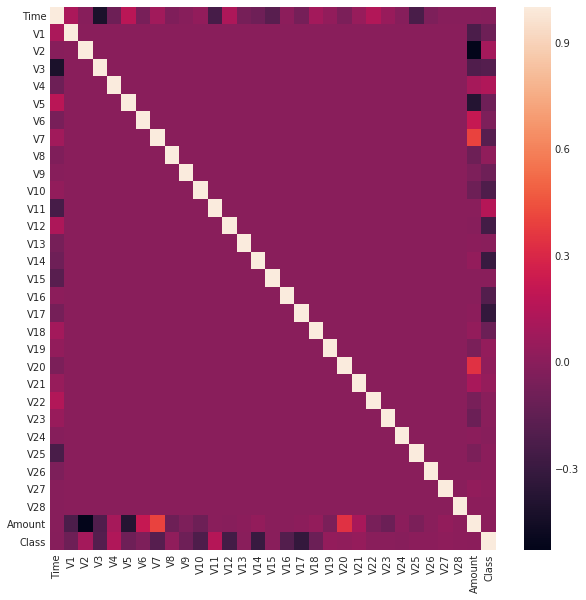

In [203]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr());

We are told that the target variable is highly unbalanced, which is to be expected of fraudulent credit card purchases. Let's take a quick look at that imbalance using a countplot.

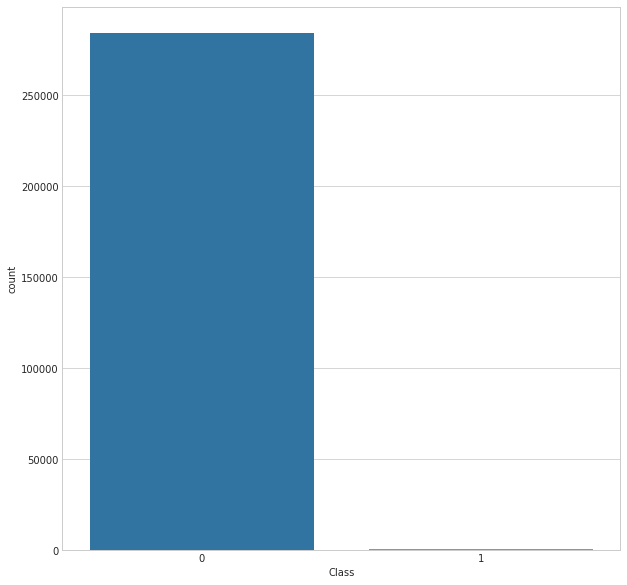

In [204]:
plt.figure(figsize=(10,10))
sns.countplot("Class", data=data);

In [205]:
data[data.Class==1].shape[0] / data[data.Class==0].shape[0]

0.0017304750013189597

Desribing the data will not be extremly helpful because most of the variables have been transforms, but we will still be able to see if we have any truly wild outliers.

In [206]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Hrm, the amount mins are a little odd. Why would we have a transaction that resulted in 0 charge?

In [207]:
data[['Time', 'Amount']].describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


In [208]:
data[data.Amount==0].shape[0]

1825

In [209]:
data[(data.Amount==0) & (data.Class==0)].shape[0]

1798

In [210]:
data[(data.Amount==0) & (data.Class==1)].shape[0]

27

In [211]:
data[(data.Amount==0) & (data.Class==1)].shape[0] / data[(data.Amount==0) & (data.Class==0)].shape[0]

0.015016685205784204

Well, 15% of the transcation resulting in an amount of 0 are fradulent, which is an increase from the 1.7% found in the entire dataset, so I am going to leave them in.

In [212]:
data.groupby('Class').mean()['Amount']

Class
0     88.291022
1    122.211321
Name: Amount, dtype: float64

In [213]:
data.groupby('Class').max()['Amount']

Class
0    25691.16
1     2125.87
Name: Amount, dtype: float64

The average fraudulent transaction is $34 more even with the extremly high max value, let's look at the distribution of amount values.

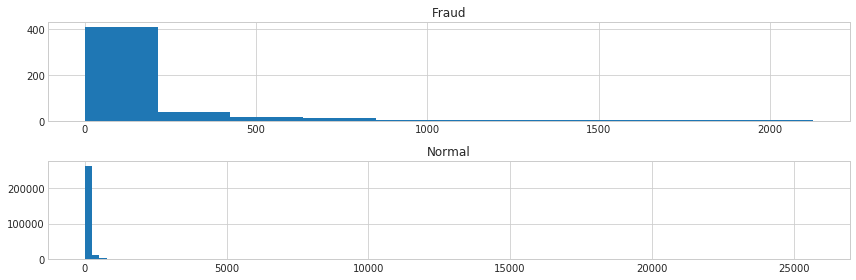

In [214]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,4))

ax1.hist(data.Amount[data.Class==1])
ax1.set_title('Fraud')

ax2.hist(data.Amount[data.Class==0], bins = 100)
ax2.set_title('Normal')

plt.tight_layout();

Let's see how many transcation we have above that 5000 limit.

In [215]:
print(data[data.Amount > 5000].shape[0])
data[(data.Amount > 5000) & (data.Class==1)].shape[0]

55


0

In [216]:
data[data.Class==1].Amount.max()

2125.87

None of the transcations over \$5000 are fradulent, in fact none over \$2,200 are. Could we take all transactions above \$2,500 and replace their value with \$2,500? We are going to scale the data, so having a smaller range might be helpful.

> I attempted to capping the data at \$3,000 and the models performed slightly worse, but not be a signifigant amount. ***The code below does not cap amount. ***

In [217]:
#amount = np.array(data['Amount'].values.tolist())
#data['Amount'] = np.where(amount > 3000, 3000, amount).tolist()

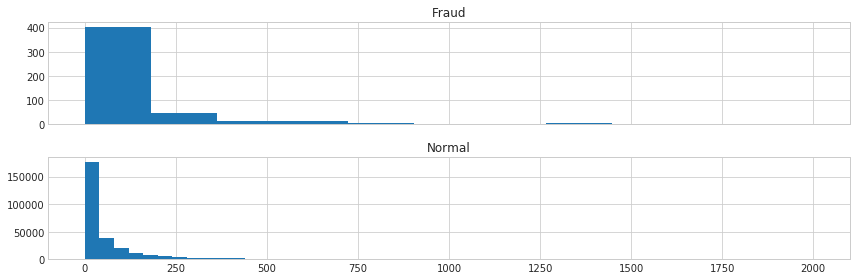

In [218]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

ax1.hist(data.Amount[(data.Class==1) & (data.Amount < 2000)])
ax1.set_title('Fraud')

ax2.hist(data.Amount[(data.Class==0) & (data.Amount < 2000)], bins = 50)
ax2.set_title('Normal')

plt.tight_layout();

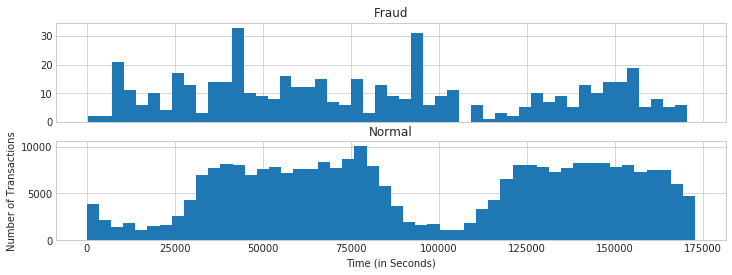

In [219]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(data.Time[data.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(data.Time[data.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

Looking at the distribution of time we can see that we should be suspicous of transcations occuring early in the morning, between 2am and 6am it looks like.  Next we are going to take a look at the distriubtions of all the variables, this could let us know which variables we want to include in the analysis.

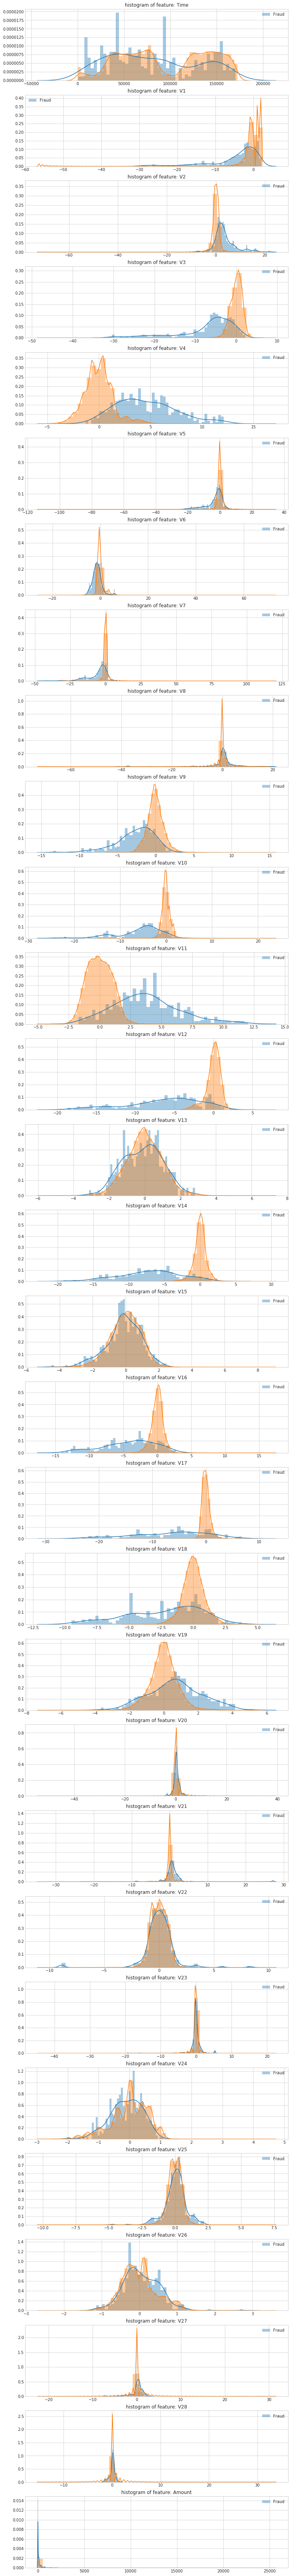

In [220]:
num_cols = len(data.columns[:-1])
plt.figure(figsize=(12,num_cols*4))
gs = gridspec.GridSpec(num_cols, 1)
for i, cn in enumerate(data[data.columns[:-1]]):
    ax = plt.subplot(gs[i])
    sns.distplot(data[cn][data.Class == 1], bins=50, label = 'Fraud')
    sns.distplot(data[cn][data.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
    ax.legend()
plt.show();

In this first notebook, I am going to include all the variables, but it looks like the anonymous variables 2, 3, 4, 7, 9, 10, 11, 12, 14, 16, 17, 18, 19, and 24 could have more importance than the others.

> When the analysis is run with only the variables mentioned above (plus amount and time), we see a very small increase in the Average Precision scores of the models, but once we start iterating through the tresholds, we see a decrease in performance. I think there could be room to engineer additional features, but the model is performing well and I'm not sure it would be worth the time. ***The analysis below includes all original variables.**

Anonymized feautres are scalled, so let's scale our amount and time features.

In [221]:
#important = ['V2', 'V3', 'V4', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'V24', 'Class', 'Amount', 'Time']
#data = data[important]

In [222]:
data["Normalized Amount"] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data["Normalized Time"] = StandardScaler().fit_transform(data['Time'].values.reshape(-1, 1))
data.drop(["Time","Amount"],axis=1,inplace=True)

Get our feature and target data;

In [223]:
X = data.drop("Class", axis=1).values
y = data['Class'].values

In [224]:
X.shape

(284807, 30)

In [225]:
y.shape

(284807,)

Let's split the data before we resample it to train our model;

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [227]:
(y_train==1).sum() / y_train.shape[0]

0.001729245759178389

In [228]:
(y_test==1).sum() / y_test.shape[0]

0.0017204452090867595

Only sampling 3% of the data each time, so let's do it a few times, say 100, and get our best params from that;

In [229]:
best_params_log = {'C': []}
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

for i in range(25):
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_sample(X_train, y_train)
    grid = GridSearchCV(LogisticRegression(), param_grid)
    grid.fit(X_resampled, y_resampled)
    best_params_log['C'].append(grid.best_params_['C'])

best_params_RFC = {'n_estimators': [], 'max_features': [],
                  'max_depth': []}

param_grid = {'n_estimators': [50, 200, 500],
              'max_features': ['auto', None, 'log2'],
              'max_depth' : [5,7,9]}

for i in range(10):
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_sample(X_train, y_train)
    grid = GridSearchCV(RandomForestClassifier(), param_grid, cv= 5)
    grid.fit(X_resampled, y_resampled)
    best_params_RFC['n_estimators'].append(grid.best_params_['n_estimators'])
    best_params_RFC['max_features'].append(grid.best_params_['max_features'])
    best_params_RFC['max_depth'].append(grid.best_params_['max_depth'])

In [230]:
best_params_SVC = {'C': []}
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

for i in range(25):
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_sample(X_train, y_train)
    grid = GridSearchCV(SVC(), param_grid)
    grid.fit(X_resampled, y_resampled)
    best_params_SVC['C'].append(grid.best_params_['C'])

In [231]:
param_grid = {'n_estimators': [50, 200, 500],
              'max_features': ['auto', None, 'log2'],
              'max_depth' : [5,7,9]}
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_sample(X_train, y_train)
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv= 5)
grid.fit(X_resampled, y_resampled)
print(grid.best_params_)

{'max_depth': 7, 'max_features': 'log2', 'n_estimators': 500}


In [232]:
np.mean(best_params_log['C'])

0.01

In [233]:
np.mean(best_params_SVC['C'])

1.0

In [234]:
GNB_scores = {'F1': [], 'prec': [], 'rec': [], 'AP': []}
LR_scores = {'F1': [], 'prec': [], 'rec': [], 'AP': []}
RFC_scores = {'F1': [], 'prec': [], 'rec': [], 'AP': []}
SVC_scores = {'F1': [], 'prec': [], 'rec': [], 'AP': []}

for i in range(25):
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_sample(X_train, y_train)
    GNB = GaussianNB()
    LR = LogisticRegression(C=0.01)
    RFC = RandomForestClassifier(n_estimators = 200, max_depth = 7, max_features = 'auto')
    SVC_ = SVC(C=1, probability=True)
    
    GNB.fit(X_resampled, y_resampled)
    LR.fit(X_resampled, y_resampled)
    RFC.fit(X_resampled, y_resampled)
    SVC_.fit(X_resampled, y_resampled)
    
    GNB_pred = GNB.predict(X_test)
    LR_pred = LR.predict(X_test)
    RFC_pred = RFC.predict(X_test)
    SVC_pred = SVC_.predict(X_test)
    
    GNB_prob = GNB.predict_proba(X_test)[:,1]
    LR_prob = LR.predict_proba(X_test)[:,1]
    RFC_prob = RFC.predict_proba(X_test)[:,1]
    SVC_prob = SVC_.predict_proba(X_test)[:,1]
    
    GNB_scores['F1'].append(f1_score(y_test, GNB_pred, average="macro"))
    GNB_scores['prec'].append(precision_score(y_test, GNB_pred, average="macro"))
    GNB_scores['rec'].append(recall_score(y_test, GNB_pred, average="macro"))  
    GNB_scores['AP'].append(average_precision_score(y_test, GNB_prob, average="macro"))
        
    LR_scores['F1'].append(f1_score(y_test, LR_pred, average="macro"))
    LR_scores['prec'].append(precision_score(y_test, LR_pred, average="macro"))
    LR_scores['rec'].append(recall_score(y_test, LR_pred, average="macro"))
    LR_scores['AP'].append(average_precision_score(y_test, LR_prob, average="macro"))
                             
    RFC_scores['F1'].append(f1_score(y_test, RFC_pred, average="macro"))
    RFC_scores['prec'].append(precision_score(y_test, RFC_pred, average="macro"))
    RFC_scores['rec'].append(recall_score(y_test, RFC_pred, average="macro")) 
    RFC_scores['AP'].append(average_precision_score(y_test, RFC_prob, average="macro"))

    SVC_scores['F1'].append(f1_score(y_test, SVC_pred, average="macro"))
    SVC_scores['prec'].append(precision_score(y_test, SVC_pred, average="macro"))
    SVC_scores['rec'].append(recall_score(y_test, SVC_pred, average="macro"))
    SVC_scores['AP'].append(average_precision_score(y_test, SVC_prob, average="macro"))

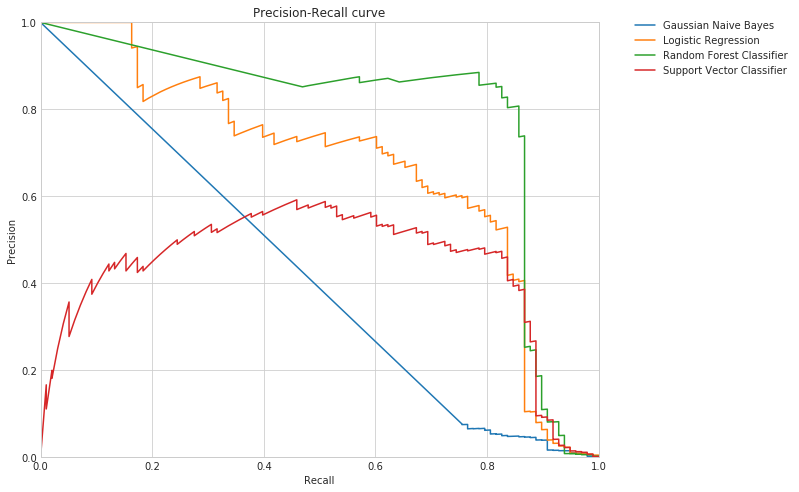

In [235]:
GNB_precision, GNB_recall, _= precision_recall_curve(y_test,GNB_prob)
LR_precision, LR_recall, _= precision_recall_curve(y_test,LR_prob)
RFC_precision, RFC_recall, _= precision_recall_curve(y_test,RFC_prob)
SVC_precision, SVC_recall, _= precision_recall_curve(y_test,SVC_prob)

plt.figure(figsize=(10,8))
plt.plot(GNB_recall, GNB_precision, label = 'Gaussian Naive Bayes')
plt.plot(LR_recall, LR_precision, label = 'Logistic Regression')
plt.plot(RFC_recall, RFC_precision, label = 'Random Forest Classifier')
plt.plot(SVC_recall, SVC_precision, label = 'Support Vector Classifier')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Precision-Recall curve')    
plt.legend(bbox_to_anchor=(1.05, 1.025));

In [236]:
print ('Gaussian Naive Bayes Scores')
print('F1: ', np.mean(GNB_scores['F1']))
print('Precision: ', np.mean(GNB_scores['prec']))
print('Recall: ', np.mean(GNB_scores['rec']))
print('Average Precision Score: ', np.mean(GNB_scores['AP']))

print('')
print('Logistic Regression Scores')
print('F1: ', np.mean(LR_scores['F1']))
print('Precision: ', np.mean(LR_scores['prec']))
print('Recall: ', np.mean(LR_scores['rec']))
print('Average Precision Score: ', np.mean(LR_scores['AP']))
print('')
print('Random Forest Classifier Scores')
print('F1: ', np.mean(RFC_scores['F1']))
print('Precision: ', np.mean(RFC_scores['prec']))
print('Recall: ', np.mean(RFC_scores['rec']))
print('Average Precision Score: ', np.mean(RFC_scores['AP']))
print('')
print('Support Vector Classifier Scores')
print('F1: ', np.mean(SVC_scores['F1']))
print('Precision: ', np.mean(SVC_scores['prec']))
print('Recall: ', np.mean(SVC_scores['rec']))
print('Average Precision Score: ', np.mean(SVC_scores['AP']))

Gaussian Naive Bayes Scores
F1:  0.5364310327022688
Precision:  0.5231953360736542
Recall:  0.9183913928542718
Average Precision Score:  0.06718270123583896

Logistic Regression Scores
F1:  0.5305230449889341
Precision:  0.5207025947237854
Recall:  0.9360385825686492
Average Precision Score:  0.6707659455374099

Random Forest Classifier Scores
F1:  0.589624864290653
Precision:  0.5517643538966669
Recall:  0.9489170150333629
Average Precision Score:  0.7479493876703646

Support Vector Classifier Scores
F1:  0.522179900473379
Precision:  0.5173418741157962
Recall:  0.9421012038749096
Average Precision Score:  0.43510121798615065


Pretty similar scores all around! We will continue with the RCF model due to it's high AP score. Now we can look at the the threshold, how sure we want to be that a transcation is a fraud, before we label it a fraud.

In [237]:
RFC = RandomForestClassifier(n_estimators = 200, max_depth = 7, max_features = 'auto' )
RFC.fit(X_resampled, y_resampled);

In [238]:
y_prob = RFC.predict_proba(X_test)

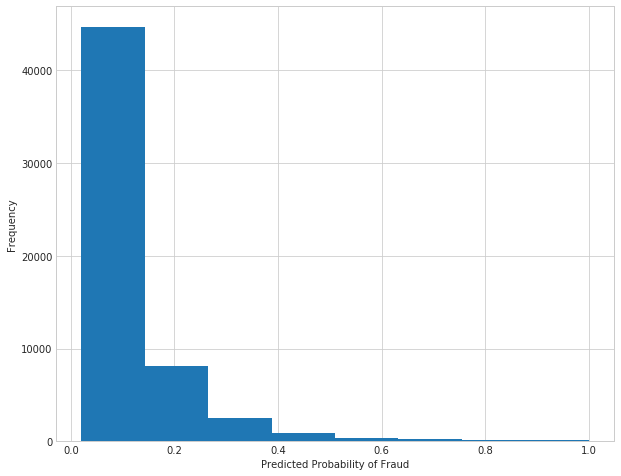

In [239]:
plt.figure(figsize=(10,8))

plt.hist(y_prob[:,1], bins=8)
plt.xlabel('Predicted Probability of Fraud')
plt.ylabel('Frequency');

We can iterate through the thresholds and see what kind of metric score we get with each one.

In [240]:
thresholds = [0.5, 0.75, 0.9, 0.95, 0.99]
for thresh in thresholds:
    y_pred = y_prob[:,1] > thresh

    print('Threshold: ', thresh)
    print('F1: ', f1_score(y_test, y_pred, average="macro"))
    print('Precision: ', precision_score(y_test, y_pred, average="macro"))
    print('Recall: ', recall_score(y_test, y_pred, average="macro")) 
    print('Average Precision Score: ' , average_precision_score(y_test, y_prob[:,1], average="macro")) #this will be the same each time, I just want to see it
    
    print('')

Threshold:  0.5
F1:  0.5881477748512243
Precision:  0.5508934244313933
Recall:  0.9471879916851378
Average Precision Score:  0.7594327900287201

Threshold:  0.75
F1:  0.7753667171442837
Precision:  0.7022664189724381
Recall:  0.9325743557130224
Average Precision Score:  0.7594327900287201

Threshold:  0.9
F1:  0.9165259850643033
Precision:  0.9253736536570693
Recall:  0.9080401645745524
Average Precision Score:  0.7594327900287201

Threshold:  0.95
F1:  0.9064439455324088
Precision:  0.9402652125937052
Recall:  0.8774630913141847
Average Precision Score:  0.7594327900287201

Threshold:  0.99
F1:  0.8534475661212307
Precision:  0.9390424208337594
Recall:  0.7958480240717558
Average Precision Score:  0.7594327900287201



When choosing a model to work with imbalanced data, confusion matrices are not as useful as they normally are. When choosing the threshold though these can tell us what sort of trade-off we're making.

In [241]:
def print_confusion_matrix(confusion_matrix, class_names, title, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(str(thresh) + ' Threshold for Fraud')
    return fig

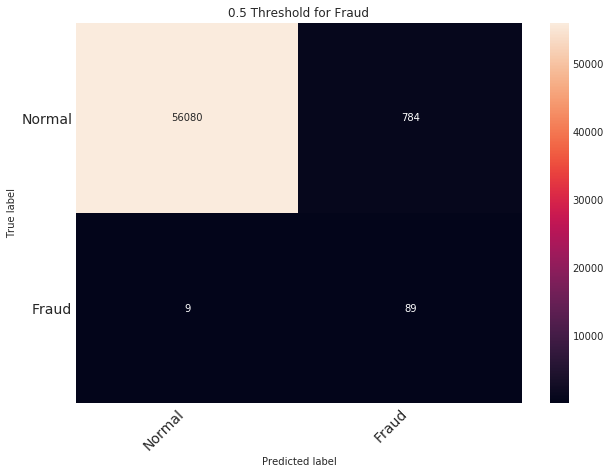

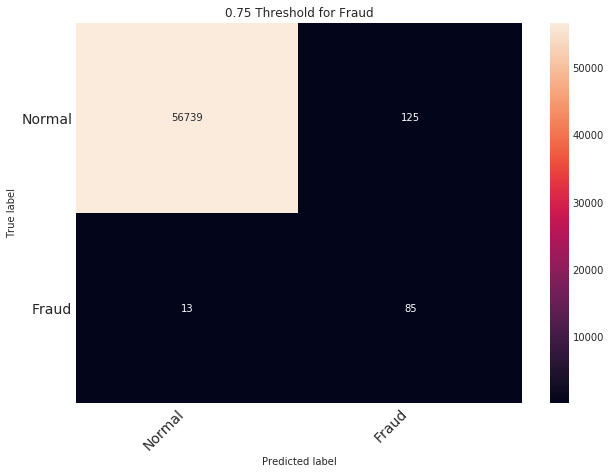

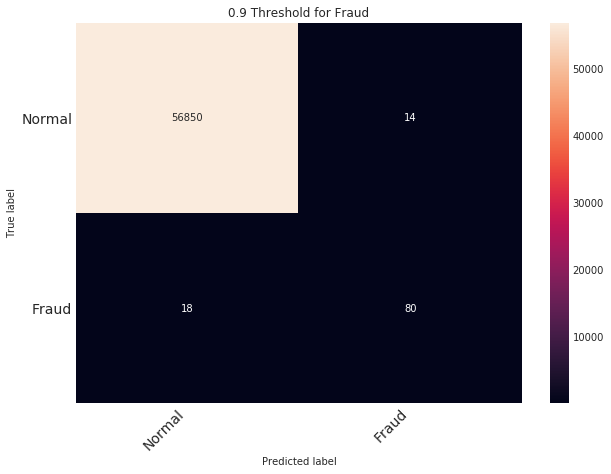

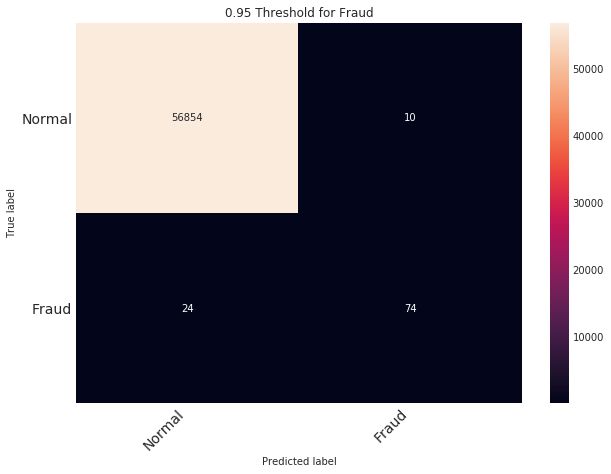

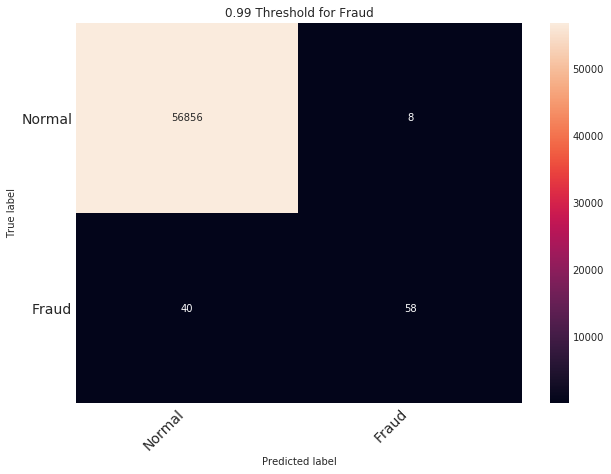

In [242]:
for thresh in thresholds:
    y_pred = y_prob[:,1] > thresh
    cm = confusion_matrix(y_test, y_pred)
    print_confusion_matrix(cm, ['Normal', 'Fraud'], title = thresh)

The threshold decision would ultimately come through a business and consumer centric discussion. At our lowest threshold we are catching more of the fraud correctly, but we are also flagging 775 normal transcations as fraud. This could create tension with consumer, if the company is declining their transactions are holding them up to investigate. That is also a large number of false positives for someone to sort through. At 0.75, we strike a much better balance, only missing 13 fraudulent transcations, but only flagging 93 normal transcations as fraudulent. If we consider 93 normal transcations being help up as too many, 0.9 might be a better balance, we are now missing 18 of our fraudulent transcation, but only 15 normal transaction will be flagged incorrectly. 

In [243]:
avg_fraud_amount = 122.21

In [244]:
for thresh in thresholds:
    y_pred = y_prob[:,1] > thresh
    cm = confusion_matrix(y_test, y_pred)
    print(str(thresh) + ' Threshold for Fraud')
    print('Percent of normal transcations flagged: ', (cm[0][1] / cm[0].sum()) * 100)
    print('Perfecnt of fraudulent transactions missed: ' , (cm[1][0] / cm[1].sum()) * 100)
    print('Amount of Fraudulent purchases allowed: $', cm[1][0] * avg_fraud_amount)
    print('Amount of Fraudulent purchases stopped: $', cm[1][1] * avg_fraud_amount)
    print('')

0.5 Threshold for Fraud
Percent of normal transcations flagged:  1.3787281935846933
Perfecnt of fraudulent transactions missed:  9.183673469387756
Amount of Fraudulent purchases allowed: $ 1099.8899999999999
Amount of Fraudulent purchases stopped: $ 10876.689999999999

0.75 Threshold for Fraud
Percent of normal transcations flagged:  0.21982273494653912
Perfecnt of fraudulent transactions missed:  13.26530612244898
Amount of Fraudulent purchases allowed: $ 1588.73
Amount of Fraudulent purchases stopped: $ 10387.85

0.9 Threshold for Fraud
Percent of normal transcations flagged:  0.024620146314012378
Perfecnt of fraudulent transactions missed:  18.367346938775512
Amount of Fraudulent purchases allowed: $ 2199.7799999999997
Amount of Fraudulent purchases stopped: $ 9776.8

0.95 Threshold for Fraud
Percent of normal transcations flagged:  0.01758581879572313
Perfecnt of fraudulent transactions missed:  24.489795918367346
Amount of Fraudulent purchases allowed: $ 2933.04
Amount of Fraudule

Is dropping .14 percentage points (78 less transcation), when both are below .2 percent already,  in our normal flagged as fraud category worth the possibility of paying back an additional 611.04 in fraud? I think this is the beginning of the conversation and more threshold could be run either between 0.5 and 0.75 (if we really want to keep the misslabaled fraud down) or between 0.75 and 0.9 if we want to keep the number of our normal transcation flagged to a minimum.  

## A Short Alernative Approach

Instead of undersampling or performing any sampling with the data, we could have used the `class_weight` parameter in `Scikit-Learn` to deal with our target variable's imbalance. 

In [245]:
clf = LogisticRegression(random_state=0, class_weight='balanced')

In [246]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [247]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

In [248]:
print('F1: ', f1_score(y_test, y_pred, average="macro"))
print('Precision: ', precision_score(y_test, y_pred, average="macro"))
print('Recall: ', recall_score(y_test, y_pred, average="macro"))
print('Average Precision Score: ' , average_precision_score(y_test, y_prob[:,1], average="macro"))

F1:  0.5529900685023593
Precision:  0.5314405770951734
Recall:  0.947418760695049
Average Precision Score:  0.7259296944454295


This performs almost as well as the Random Forest we training, it's results from above are below;

`Random Forest Classifier Scores
F1:  0.5903599162486466
Precision:  0.5522256295389935
Recall:  0.9457667201658378
Average Precision Score:  0.7518286705584167`

In [249]:
thresholds = [0.5, 0.75, 0.9, 0.95, 0.99]
for thresh in thresholds:
    y_pred = y_prob[:,1] > thresh

    print('Threshold: ', thresh)
    print('F1: ', f1_score(y_test, y_pred, average="macro"))
    print('Precision: ', precision_score(y_test, y_pred, average="macro"))
    print('Recall: ', recall_score(y_test, y_pred, average="macro")) 
    print('')

Threshold:  0.5
F1:  0.5529900685023593
Precision:  0.5314405770951734
Recall:  0.947418760695049

Threshold:  0.75
F1:  0.6260872478400754
Precision:  0.574555892091557
Recall:  0.9546729109482848

Threshold:  0.9
F1:  0.707285022962989
Precision:  0.6369820386149281
Recall:  0.9316950647732363

Threshold:  0.95
F1:  0.7885700157031923
Precision:  0.7167222295323372
Recall:  0.9326974564445925

Threshold:  0.99
F1:  0.8658075763286845
Precision:  0.8252560695378628
Recall:  0.9179804589252696



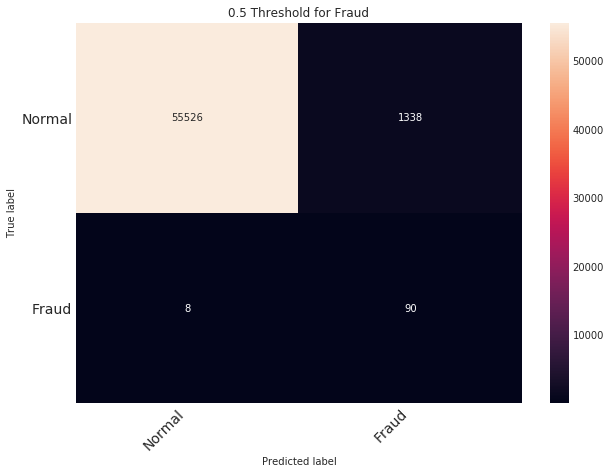

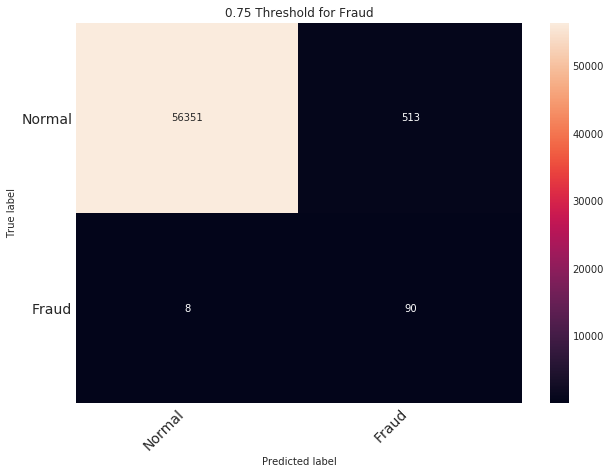

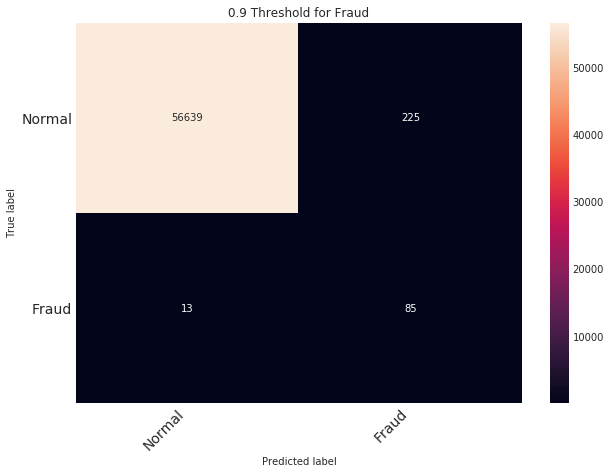

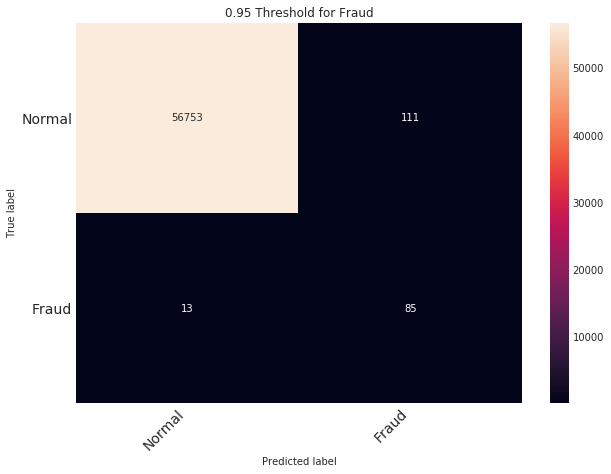

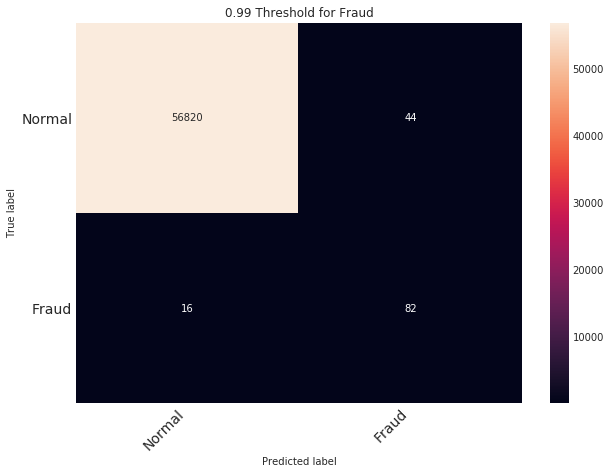

In [250]:
for thresh in thresholds:
    y_pred = y_prob[:,1] > thresh
    cm = confusion_matrix(y_test, y_pred)
    print_confusion_matrix(cm, ['Normal', 'Fraud'], title = thresh)

In [251]:
for thresh in thresholds:
    y_pred = y_prob[:,1] > thresh
    cm = confusion_matrix(y_test, y_pred)
    print(str(thresh) + ' Threshold for Fraud')
    print('Percent of normal transcations flagged: ', (cm[0][1] / cm[0].sum()) * 100)
    print('Perfecnt of fraudulent transactions missed: ' , (cm[1][0] / cm[1].sum()) * 100)
    print('Amount of Fraudulent purchases allowed: $', cm[1][0] * avg_fraud_amount)
    print('Amount of Fraudulent purchases stopped: $', cm[1][1] * avg_fraud_amount)
    print('')

0.5 Threshold for Fraud
Percent of normal transcations flagged:  2.3529825548677543
Perfecnt of fraudulent transactions missed:  8.16326530612245
Amount of Fraudulent purchases allowed: $ 977.68
Amount of Fraudulent purchases stopped: $ 10998.9

0.75 Threshold for Fraud
Percent of normal transcations flagged:  0.9021525042205966
Perfecnt of fraudulent transactions missed:  8.16326530612245
Amount of Fraudulent purchases allowed: $ 977.68
Amount of Fraudulent purchases stopped: $ 10998.9

0.9 Threshold for Fraud
Percent of normal transcations flagged:  0.39568092290377044
Perfecnt of fraudulent transactions missed:  13.26530612244898
Amount of Fraudulent purchases allowed: $ 1588.73
Amount of Fraudulent purchases stopped: $ 10387.85

0.95 Threshold for Fraud
Percent of normal transcations flagged:  0.19520258863252674
Perfecnt of fraudulent transactions missed:  13.26530612244898
Amount of Fraudulent purchases allowed: $ 1588.73
Amount of Fraudulent purchases stopped: $ 10387.85

0.99 T

We can see here the results are very similar, but we tend to do a worse in regards to falsely flagging normal transcations as fraud, without improving our percent of fraudlent transcations identified much.  Still, 0.75 here does land us with under 1% of normal transcation identified incorrectly, which is still 513 misidentified, but we save $611.05 in fraudulent purchases compared to our Random Forest at 0.75.

I understand that these sort of values cannot be extrapolated out in a linear fashion (not all curves are lines) , but I thought it would be fun to see how much these models and threshold might save (and flag falsely) if we take these two days of data, and turn it into and entire year.

In [253]:
print ('RCF 0.75 Threshold')
print('Incorrectly Flagged Transcations', 93 * 182.5)
print('Fraud Allowed: $', 1588.73 * 182.5)
print('Fraud Stopped: $', 10387.85 * 182.5)
print('')
print ('RCF 0.9 Threshold')
print('Incorrectly Flagged Transcations', 15 * 182.5)
print('Fraud Allowed: $', 2199.77 * 182.5)
print('Fraud Stopped: $', 9776.83 * 182.5)
print('')
print ('Logistic 0.75 Threshold')
print('Incorrectly Flagged Transcations', 513 * 182.5)
print('Fraud Allowed: $', 977.68 * 182.5)
print('Fraud Stopped: $', 10998.90 * 182.5)
print('')
print ('Logistic 0.95 Threshold')
print('Incorrectly Flagged Transcations', 111 * 182.5)
print('Fraud Allowed: $', 1588.73 * 182.5)
print('Fraud Stopped: $', 10387.85 * 182.5)
print('')

RCF 0.75 Threshold
Incorrectly Flagged Transcations 16972.5
Fraud Allowed: $ 289943.225
Fraud Stopped: $ 1895782.625

RCF 0.9 Threshold
Incorrectly Flagged Transcations 2737.5
Fraud Allowed: $ 401458.025
Fraud Stopped: $ 1784271.475

Logistic 0.75 Threshold
Incorrectly Flagged Transcations 93622.5
Fraud Allowed: $ 178426.59999999998
Fraud Stopped: $ 2007299.25

Logistic 0.95 Threshold
Incorrectly Flagged Transcations 20257.5
Fraud Allowed: $ 289943.225
Fraud Stopped: $ 1895782.625

